In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import lenstronomy.Util.param_util as param_util
from baobab import bnn_priors

from baobab.configs import BaobabConfig
import baobab.configs.real_source_config as my_config

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Visualizing the input prior PDF in the GalsimSourcePrior and the resulting samples
__Author:__ Aymeric Galan, from Ji Won Park's notebook
    
__Created:__ 1/20/20
    
__Last run:__ 2/20/20

__Goals:__
Plot the (marginal) distributions of the parameters sampled from the diagonal BNN prior, in which all parameters are assumed to be independent.

__Before running this notebook:__
Generate some data. At the root of the `baobab` repo, run:
```
generate baobab/configs/galsim_source_config.py --n_data 1000
```
This generates 1000 samples using `GalsimSourcePrior` at the location this notebook expects.

In [2]:
cfg_path = my_config.__file__
#cfg_path = os.path.join('..', '..', 'time_delay_lens_modeling_challenge', 'data', 'baobab_configs', 'train_tdlmc_diagonal_config.py')
cfg = BaobabConfig.from_file(cfg_path)
#out_data_dir = os.path.join('..', '..', 'time_delay_lens_modeling_challenge', cfg.out_dir)
out_data_dir = os.path.join('..', cfg.out_dir)
print(out_data_dir)
meta = pd.read_csv(os.path.join(out_data_dir, 'metadata.csv'), index_col=None)
bnn_prior = getattr(bnn_priors, cfg.bnn_prior_class)(cfg.bnn_omega, cfg.components, cfg.external)

/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Forked/baobab_forked/demo_test/galsim_test


Here are the parameters available. 

In [3]:
sorted(meta.columns.values)

['external_shear_dec_0',
 'external_shear_gamma_ext',
 'external_shear_psi_ext',
 'external_shear_ra_0',
 'img_filename',
 'lens_mass_center_x',
 'lens_mass_center_y',
 'lens_mass_e1',
 'lens_mass_e2',
 'lens_mass_gamma',
 'lens_mass_theta_E',
 'src_light_amp',
 'src_light_catalog_index',
 'src_light_center_x',
 'src_light_center_y',
 'src_light_galsim_angle',
 'src_light_galsim_center_x',
 'src_light_galsim_center_y',
 'src_light_galsim_scale',
 'src_light_magnitude',
 'src_light_phi_G',
 'src_light_scale',
 'total_magnification']

In [4]:
# Add shear and ellipticity modulus and angle
if 'external_shear_gamma_ext' in meta.columns.values:
    gamma_ext = meta['external_shear_gamma_ext'].values
    psi_ext = meta['external_shear_psi_ext'].values
    gamma1, gamma2 = param_util.shear_polar2cartesian(psi_ext, gamma_ext)
    meta['external_shear_gamma1'] = gamma1
    meta['external_shear_gamma2'] = gamma2
else:
    gamma1 = meta['external_shear_gamma1'].values
    gamma2 = meta['external_shear_gamma2'].values
    psi_ext, gamma_ext = param_util.shear_cartesian2polar(gamma1, gamma2)
    meta['external_shear_gamma_ext'] = gamma_ext
    meta['external_shear_psi_ext'] = psi_ext
for comp in cfg.components:
    if comp in ['lens_mass', 'src_light', 'lens_light']:
        if '{:s}_e1'.format(comp) in meta.columns.values:
            e1 = meta['{:s}_e1'.format(comp)].values
            e2 = meta['{:s}_e2'.format(comp)].values
            phi, q = param_util.ellipticity2phi_q(e1, e2)
            meta['{:s}_q'.format(comp)] = q
            meta['{:s}_phi'.format(comp)] = phi
        else:
            pass
            #q = meta['{:s}_q'.format(comp)].values
            #phi = meta['{:s}_phi'.format(comp)].values
            #e1, e2 = param_util.phi_q2_ellipticity(phi, q)
            #meta['{:s}_e1'.format(comp)] = e1
            #meta['{:s}_e2'.format(comp)] = e2

In [30]:
# Add source gal positional offset

# WARNING : the real offset is 'galsim_center_x' instead of lenstronomy's center_x when using galsim

#meta['src_pos_offset'] = np.sqrt(meta['src_light_center_x']**2.0 + meta['src_light_center_y']**2.0)
meta['src_pos_offset'] = np.sqrt(meta['src_light_galsim_center_x']**2.0 + meta['src_light_galsim_center_y']**2.0)


In [31]:
def plot_prior_samples(eval_at, component, param, unit):
    param_key = '{:s}_{:s}'.format(component, param)
    if param_key == 'src_light_pos_offset_x':
        hyperparams = cfg.bnn_omega['src_light']['center_x']
    elif param_key == 'src_light_pos_offset_y':
        hyperparams = cfg.bnn_omega['src_light']['center_y']
    elif (param_key == 'src_light_center_x') or (param_key == 'src_light_center_y'):
        raise NotImplementedError("Use `plot_derived_quantities` instead.")
    elif (component, param) in bnn_prior.params_to_exclude:
        raise NotImplementedError("This parameter wasn't sampled independently. Please use `plot_derived_quantities` instead.")
    else:
        hyperparams = cfg.bnn_omega[component][param].copy()
    pdf_eval = bnn_prior.eval_param_pdf(eval_at, hyperparams)
    plt.plot(eval_at, pdf_eval, 'r-', lw=2, alpha=0.6, label='PDF')
    binning = np.linspace(eval_at[0], eval_at[-1], 50)
    plt.hist(meta[param_key], bins=binning, edgecolor='k', density=True, align='mid', label='sampled')
    print(hyperparams)
    plt.xlabel("{:s} ({:s})".format(param_key, unit))
    plt.ylabel("density")
    plt.legend()

In [32]:
def plot_derived_quantities(param_key, unit, binning=None):
    binning = 30 if binning is None else binning
    _ = plt.hist(meta[param_key], bins=binning, edgecolor='k', density=True, align='mid', label='sampled')
    plt.xlabel("{:s} ({:s})".format(param_key, unit))
    plt.ylabel("density")
    plt.legend()

## Lens mass params

{'dist': 'normal', 'mu': 1.6, 'sigma': 0.05, 'lower': 0.4, 'upper': 2}


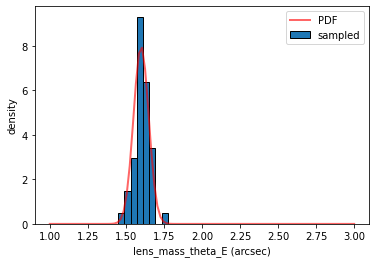

In [8]:
plot_prior_samples(np.linspace(1, 3, 100), 'lens_mass', 'theta_E', 'arcsec')

{'dist': 'normal', 'mu': 0.0, 'sigma': 1e-06}


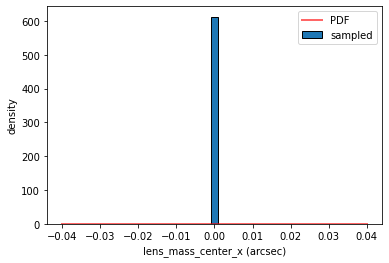

In [9]:
plot_prior_samples(np.linspace(-0.04, 0.04, 100), 'lens_mass', 'center_x', 'arcsec')

{'dist': 'normal', 'mu': 0.0, 'sigma': 1e-06}


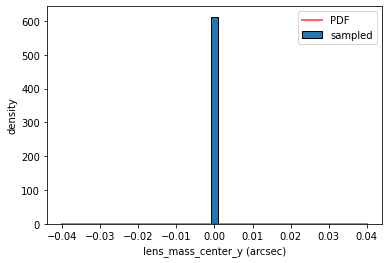

In [10]:
plot_prior_samples(np.linspace(-0.04, 0.04, 100), 'lens_mass', 'center_y', 'arcsec')

{'dist': 'normal', 'mu': 2, 'sigma': 0.05, 'lower': 1.8, 'upper': 2.2}


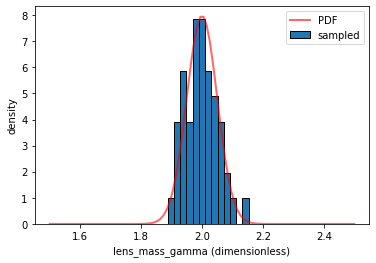

In [11]:
plot_prior_samples(np.linspace(1.5, 2.5, 100), 'lens_mass', 'gamma', 'dimensionless')

{'dist': 'beta', 'a': 4.0, 'b': 4.0, 'lower': -0.5, 'upper': 0.5}


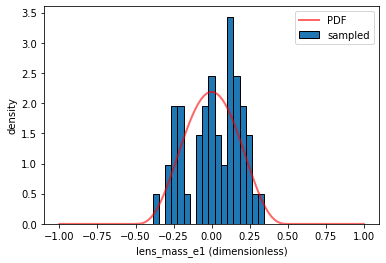

In [12]:
plot_prior_samples(np.linspace(-1.0, 1.0, 100), 'lens_mass', 'e1', 'dimensionless')

{'dist': 'beta', 'a': 4.0, 'b': 4.0, 'lower': -0.5, 'upper': 0.5}


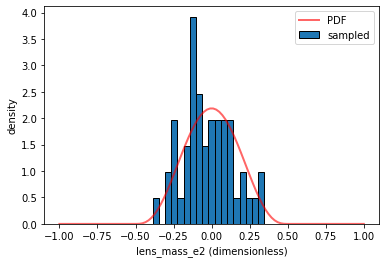

In [13]:
plot_prior_samples(np.linspace(-1.0, 1.0, 100), 'lens_mass', 'e2', 'dimensionless')

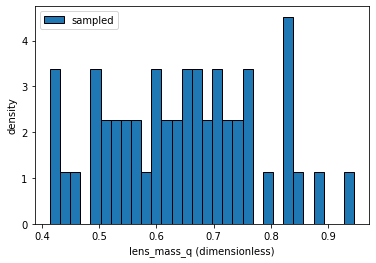

In [14]:
plot_derived_quantities('lens_mass_q', 'dimensionless')

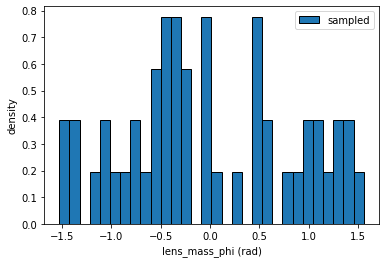

In [15]:
plot_derived_quantities('lens_mass_phi', 'rad')

## External shear params

{'dist': 'normal', 'mu': 0, 'sigma': 0.05}


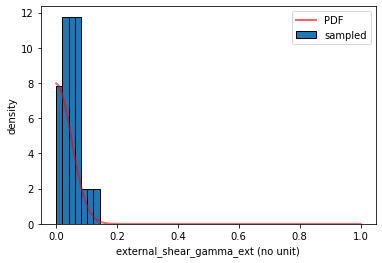

In [16]:
plot_prior_samples(np.linspace(0, 1.0, 100), 'external_shear', 'gamma_ext', 'no unit')

{'dist': 'normal', 'mu': 0, 'sigma': 0.05, 'lower': -3.141592653589793, 'upper': 3.141592653589793}


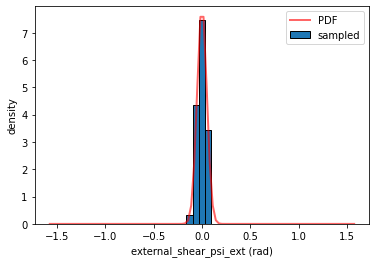

In [17]:
plot_prior_samples(np.linspace(-0.5*np.pi, 0.5*np.pi, 100), 'external_shear', 'psi_ext', 'rad')

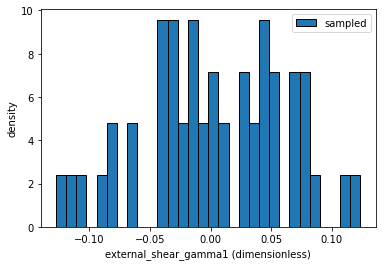

In [18]:
plot_derived_quantities('external_shear_gamma1', 'dimensionless')

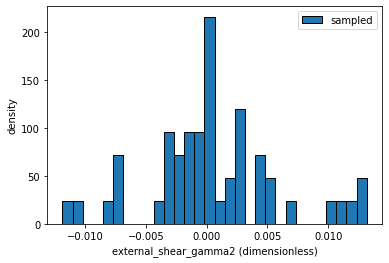

In [19]:
plot_derived_quantities('external_shear_gamma2', 'dimensionless')

## Source light params

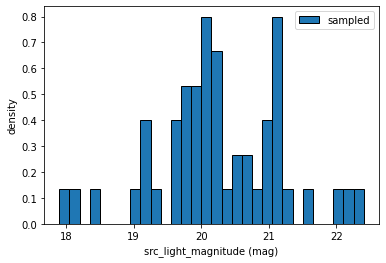

In [20]:
plot_derived_quantities('src_light_magnitude', 'mag')

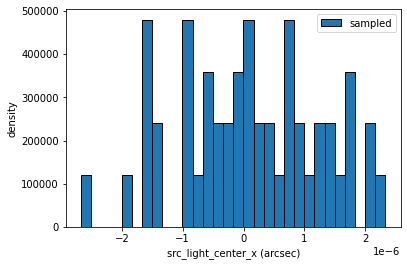

In [21]:
plot_derived_quantities('src_light_center_x', 'arcsec')

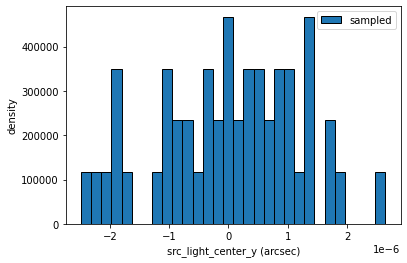

In [22]:
plot_derived_quantities('src_light_center_y', 'arcsec')

{'dist': 'uniform', 'lower': 0, 'upper': 95}


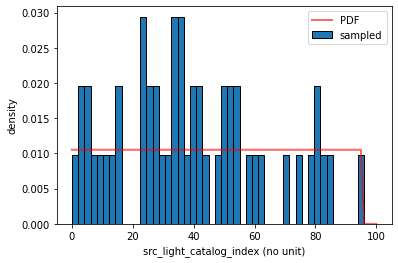

In [23]:
plot_prior_samples(np.linspace(0, 100, 100), 'src_light', 'catalog_index', 'no unit')

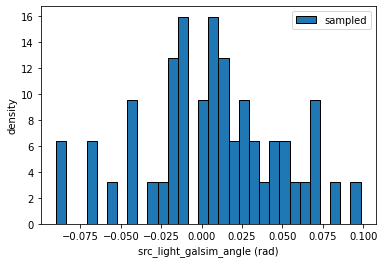

In [24]:
plot_derived_quantities('src_light_galsim_angle', 'rad')

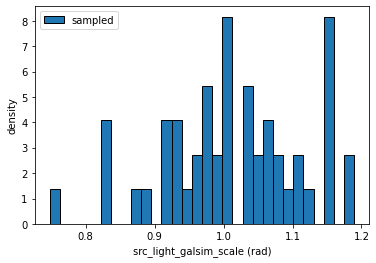

In [25]:
plot_derived_quantities('src_light_galsim_scale', 'rad')

## Total magnification

/Users/aymericg/anaconda3/envs/galsim/lib/python3.6/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


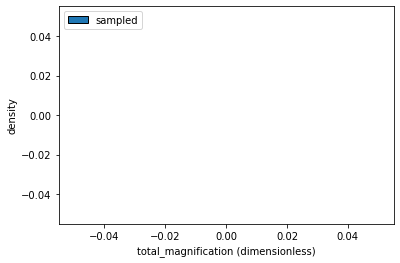

In [26]:
plot_derived_quantities('total_magnification', 'dimensionless', binning=np.linspace(0, 300, 50))

## Pairwise distributions

In [27]:
def plot_pairwise_dist(df, cols, fig=None):
    n_params = len(cols)
    plot = corner.corner(meta[cols],
                        color='tab:blue', 
                        smooth=1.0, 
                        labels=cols,
                        show_titles=True,
                        fill_contours=True,
                        levels=[0.68, 0.95, 0.997],
                        fig=fig,
                        range=[0.99]*n_params,
                        hist_kwargs=dict(density=True, ))
    return plot

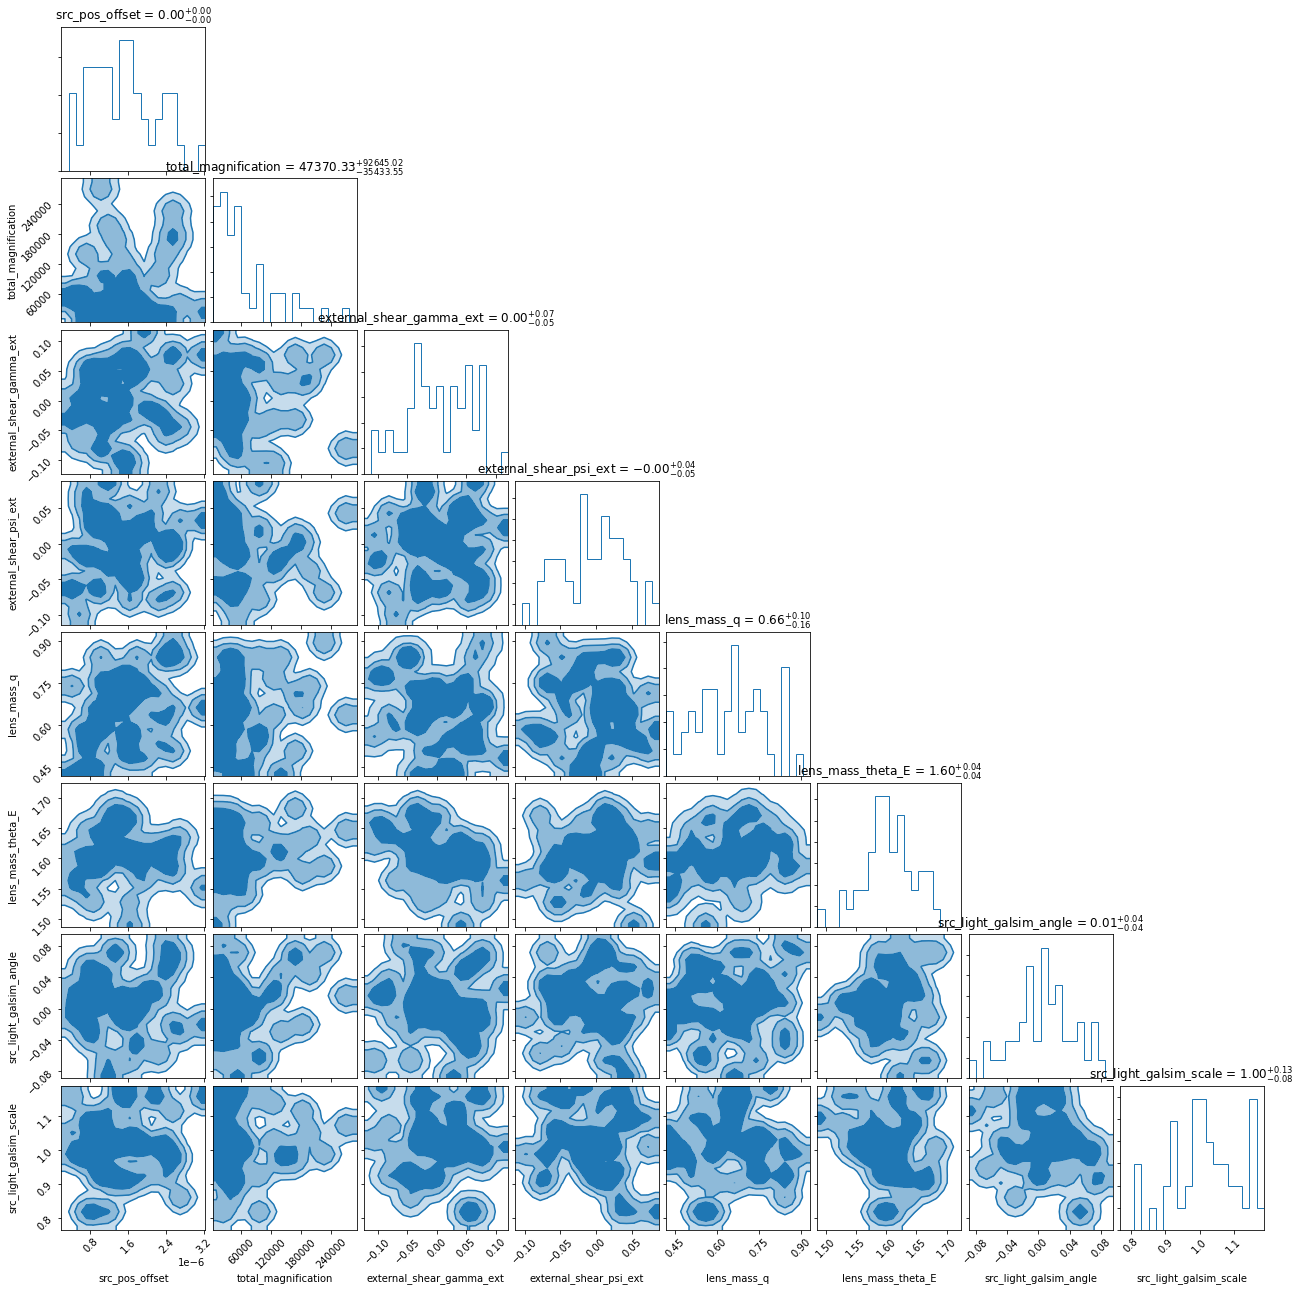

In [28]:
cols = ['src_pos_offset', 'total_magnification',
        'external_shear_gamma_ext', 'external_shear_psi_ext',
        'lens_mass_q', 'lens_mass_theta_E',
        'src_light_galsim_angle', 'src_light_galsim_scale']
_ = plot_pairwise_dist(meta, cols)

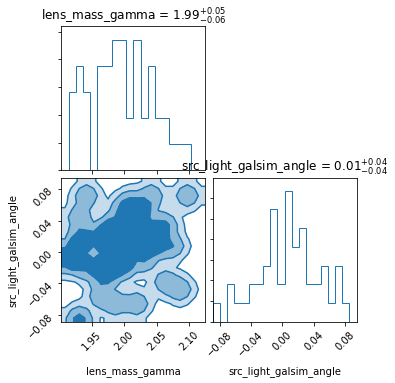

In [29]:
cols = ['lens_mass_gamma', 'src_light_galsim_angle']
_ = plot_pairwise_dist(meta, cols)